In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    TargetEncoder,
    FunctionTransformer,
)

sklearn.set_config(transform_output="pandas")

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import lightgbm as lgb

import xgboost as xgb

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)

# tunning hyperparamters model
import optuna

##### Преобразуем некоторые features

In [540]:
def new_features(X):
    X["TotalBsmtBath"] = (
        X["BsmtFullBath"] + X["BsmtHalfBath"] * 0.5
    )  # считаем сколько санузлов в подвале, HalfBath умножили на 0.5, потому что это половина)))
    X["TotalBath"] = X["FullBath"] + X["HalfBath"] * 0.5  # то же самое
    X["TotalSquare"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
    X["GarageAgeYrs"] = X["YrSold"] - X["GarageYrBlt"]
    X["TotalLivArea"] = (
        X["GrLivArea"] + X["BsmtFinSF1"] + X["BsmtFinSF2"]
    )  # считаем общую жилую площадь
    X["TotalRooms"] = X["TotRmsAbvGrd"] + X["BedroomAbvGr"]
    X["Age"] = X["YrSold"] - X["YearBuilt"]
    return X

In [541]:
train = pd.read_csv("./data/train.csv")

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [542]:
X = train.drop("SalePrice", axis=1).copy()
y = np.log(train["SalePrice"].copy())

In [543]:
X = new_features(X)

In [544]:
X.shape

(1460, 87)

#### Делаем список с количеством уникальных значений по колонкам

In [545]:
num_of_unique = {}
for c in X.columns:
    num_of_unique[c] = X[c].nunique()
num_of_unique

{'Id': 1460,
 'MSSubClass': 15,
 'MSZoning': 5,
 'LotFrontage': 110,
 'LotArea': 1073,
 'Street': 2,
 'Alley': 2,
 'LotShape': 4,
 'LandContour': 4,
 'Utilities': 2,
 'LotConfig': 5,
 'LandSlope': 3,
 'Neighborhood': 25,
 'Condition1': 9,
 'Condition2': 8,
 'BldgType': 5,
 'HouseStyle': 8,
 'OverallQual': 10,
 'OverallCond': 9,
 'YearBuilt': 112,
 'YearRemodAdd': 61,
 'RoofStyle': 6,
 'RoofMatl': 8,
 'Exterior1st': 15,
 'Exterior2nd': 16,
 'MasVnrType': 3,
 'MasVnrArea': 327,
 'ExterQual': 4,
 'ExterCond': 5,
 'Foundation': 6,
 'BsmtQual': 4,
 'BsmtCond': 4,
 'BsmtExposure': 4,
 'BsmtFinType1': 6,
 'BsmtFinSF1': 637,
 'BsmtFinType2': 6,
 'BsmtFinSF2': 144,
 'BsmtUnfSF': 780,
 'TotalBsmtSF': 721,
 'Heating': 6,
 'HeatingQC': 5,
 'CentralAir': 2,
 'Electrical': 5,
 '1stFlrSF': 753,
 '2ndFlrSF': 417,
 'LowQualFinSF': 24,
 'GrLivArea': 861,
 'BsmtFullBath': 4,
 'BsmtHalfBath': 3,
 'FullBath': 4,
 'HalfBath': 3,
 'BedroomAbvGr': 8,
 'KitchenAbvGr': 4,
 'KitchenQual': 4,
 'TotRmsAbvGrd': 12,

#### Список с кол-вом nan по колонкам

In [546]:
nan_count = pd.DataFrame(data={"NaN_count": X.isna().sum(), "data_type": X.dtypes})
cols_with_nans = nan_count[nan_count["NaN_count"] > 0].copy()
cols_with_nans

,NaN_count,data_type
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


In [547]:
cols_with_nans.shape[0]

20

In [548]:
X[X["GarageType"] == "NA"]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,TotalBsmtBath,TotalBath,TotalSquare,GarageAgeYrs,TotalLivArea,TotalRooms,Age


#### Разделяем num и cat features по описанию в data_description.txt

In [549]:
num_features = [
    "LotFrontage",
    "LotArea",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageYrBlt",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
    "TotalSquare",
    "TotalBath",
    "TotalBsmtBath",
    "GarageAgeYrs",
    "Age",
    "TotalRooms",
    "TotalLivArea",
]
cat_features = []
for c in X.columns:
    if c not in num_features and c != "Id":
        cat_features.append(c)

print(len(num_features), sep=" ")
print(len(cat_features), sep=" ")
print(len(cat_features) + len(num_features) == X.shape[1] - 1)

30
56
True


#### Проверяем все ли num признаки имеют праильный тип данных

In [550]:
X.loc[::, num_features].dtypes.value_counts()

int64      24
float64     6
Name: count, dtype: int64

#### Посмотрим распределение цены в тренировочном датасете

''

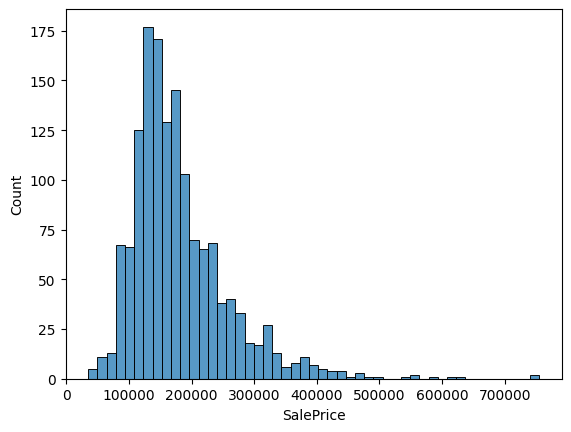

In [551]:
sns.histplot(train["SalePrice"])
;

##### Также посмотрим в логарифме

''

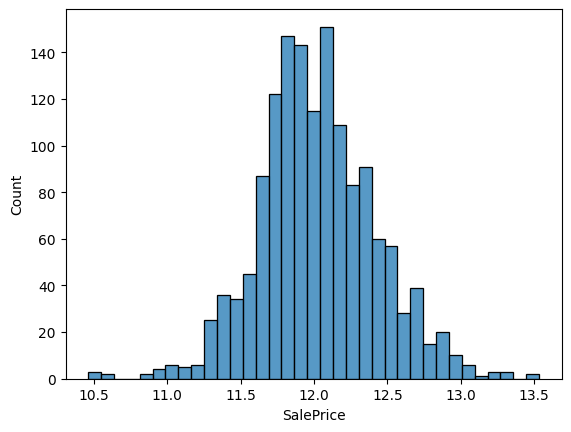

In [552]:
sns.histplot(y)
;

> **У цены хорошее распределение близкое к нормальному, отсутствуют большие выбросы. Все цены лежат в диапазоне 50к - 750к, что лежит примерно в 1 порядке.**

#### Предобработка

In [553]:
cols_with_nans

,NaN_count,data_type
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


**Bad features**
| Feature | F-score |
| ----------|----------|
|Condition2      |0.959591|
|GarageQual      |0.877147|
|BsmtFinSF2      |0.853630|
|BsmtHalfBath    |0.844157|
|BsmtFinType2    |0.660543|
|Utilities       |0.629609|
|Id              |0.493315|
|MiscVal         |0.444619|
|GarageCond      |0.432048|
|BsmtCond        |0.395944|
|LandContour     |0.216837|
|MSSubClass      |0.175365|
|SaleType        |0.160511|
|OverallCond     |0.159132|
|YrSold          |0.154710|
|LowQualFinSF    |0.147104|
|LandSlope       |0.141193|



##### Imputer

In [554]:
drop_features = [
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MasVnrType",
    "Alley",
    "OverallCond",
    "GarageQual",
    "GarageCond",
    "LandContour",
    "MSSubClass",
    "SaleType",
    "LowQualFinSF",
    "LandSlope",
    "MiscVal",
    "Utilities",
    "GarageArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GarageType",
    "GarageYrBlt",
    "GarageFinish",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "GrLivArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "TotRmsAbvGrd",
    "BedroomAbvGr",
    "YrSold",
    "YearBuilt",
]

rest_cat_features = [
    c for c in cat_features if c not in drop_features
]  # все недропнутые категориальные
rest_cat_num_features = [
    c for c in rest_cat_features if X[c].dtypes == int
]  # отбираем те, которые с цифрами
rest_cat_str_features = [
    c for c in rest_cat_features if c not in rest_cat_num_features
]  # отбираем те,которые с буквами
rest_num_features = [
    c for c in num_features if c not in drop_features
]  # числовые признаки

imputer = ColumnTransformer(
    transformers=[
        ("drop_features", "drop", drop_features),
        (
            "imput_no",
            SimpleImputer(strategy="constant", fill_value="no"),
            rest_cat_str_features,
        ),  # type: ignore
        (
            "imput_0",
            SimpleImputer(strategy="constant", fill_value=0),
            rest_cat_num_features,
        ),
        (
            "imput_numeric",
            SimpleImputer(strategy="median"),
            rest_num_features,
            # [c for c in num_features if c not in drop_features],
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
# list(set(cat_features) - set(drop_features))
# len([c for c in cat_features if c not in drop_features])
rest_cat_num_features

['OverallQual', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'MoSold']

##### Scaler

In [555]:
scaler = ColumnTransformer(
    [("scaling_num_columns", StandardScaler(), rest_num_features)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

##### Encoder

In [556]:
def float_to_int(x):
    return x.astype(int)


to_int = FunctionTransformer(float_to_int)

encoder = ColumnTransformer(
    [("encoding", make_pipeline(OrdinalEncoder(), to_int), rest_cat_features)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

##### Grouping in a preprocessor pipeline

In [557]:
preprocessor = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("scaler", scaler),
    ]
)

#### Преобразуем датасет по пайплайну

In [558]:
X_preproc = preprocessor.fit_transform(X.copy())

#### Разделяем датасет на train и valid части

In [559]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_preproc, y, test_size=0.2, random_state=42
)

In [560]:
X_train.head()

,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,BsmtUnfSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,...,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,MoSold,SaleCondition,Id
254,0.006190,-0.212153,-1.350194,-0.570750,-0.396727,1.243102,-0.704483,-0.359325,-0.116339,-0.270208,...,1,3,6,0,5,1,2,5,4,255
1066,-0.493353,-0.268578,0.442586,-0.570750,0.524681,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,...,1,3,6,1,4,2,2,4,4,1067
638,-0.130049,-0.174369,-1.689368,-0.570750,0.517889,1.865628,-0.704483,2.324878,-0.116339,-0.270208,...,1,3,6,0,5,0,1,4,4,639
799,-0.447940,-0.332419,-1.689368,0.824062,-0.917424,-0.752176,-0.704483,3.961587,-0.116339,-0.270208,...,1,2,6,2,4,1,2,5,4,800
380,-0.902070,-0.552908,-1.689368,-0.570750,0.545056,-0.752176,-0.704483,3.601511,-0.116339,-0.270208,...,1,2,6,1,2,1,2,4,4,381


#### Задаем и обучаем модель

In [561]:
model = CatBoostRegressor(random_seed=42, cat_features=rest_cat_features)
model.fit(X_train, y_train)

Learning rate set to 0.04196
0:	learn: 0.3795901	total: 7.21ms	remaining: 7.2s
1:	learn: 0.3699717	total: 14ms	remaining: 7s
2:	learn: 0.3601149	total: 22.2ms	remaining: 7.36s
3:	learn: 0.3504978	total: 29.8ms	remaining: 7.43s
4:	learn: 0.3413773	total: 37.3ms	remaining: 7.42s
5:	learn: 0.3325698	total: 43.8ms	remaining: 7.25s
6:	learn: 0.3241935	total: 52.4ms	remaining: 7.44s
7:	learn: 0.3162896	total: 59.8ms	remaining: 7.42s
8:	learn: 0.3080186	total: 65.4ms	remaining: 7.2s
9:	learn: 0.3007429	total: 71.2ms	remaining: 7.05s
10:	learn: 0.2934095	total: 80.2ms	remaining: 7.21s
11:	learn: 0.2859284	total: 89.9ms	remaining: 7.4s
12:	learn: 0.2798132	total: 95.3ms	remaining: 7.24s
13:	learn: 0.2737301	total: 101ms	remaining: 7.13s
14:	learn: 0.2673787	total: 107ms	remaining: 7.02s
15:	learn: 0.2616397	total: 117ms	remaining: 7.17s
16:	learn: 0.2562010	total: 124ms	remaining: 7.18s
17:	learn: 0.2513882	total: 132ms	remaining: 7.21s
18:	learn: 0.2462024	total: 141ms	remaining: 7.29s
19:	lea

#### Проверка модели

In [562]:
# Для тренировочных данных
train_pred = model.predict(X_train)
print("MAE train:", mean_absolute_error(y_train, train_pred))
print("MSE train:", mean_squared_error(y_train, train_pred))
print("R2 train:", r2_score(y_train, train_pred))

# Для валидационных данных
valid_pred = model.predict(X_valid)
print("MAE valid:", mean_absolute_error(y_valid, valid_pred))
print("MSE valid:", mean_squared_error(y_valid, valid_pred))
print("R2 valid:", r2_score(y_valid, valid_pred))

MAE train: 0.04716923578309973
MSE train: 0.00430604472755292
R2 train: 0.9717533405099771
MAE valid: 0.08867056179157258
MSE valid: 0.018286295212223865
R2 valid: 0.9020098040918312


#### Предсказываем на тестовых данных

In [563]:
test = pd.read_csv("./data/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [564]:
test_new_features = new_features(test.copy())
test_new_features

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,TotalBsmtBath,TotalBath,TotalSquare,GarageAgeYrs,TotalLivArea,TotalRooms,Age
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,2010,WD,Normal,0.0,1.0,1778.0,49.0,1508.0,7,49
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,2010,WD,Normal,0.0,1.5,2658.0,52.0,2252.0,9,52
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,2010,WD,Normal,0.0,2.5,2557.0,13.0,2420.0,9,13
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,2010,WD,Normal,0.0,2.5,2530.0,12.0,2206.0,10,12
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,2010,WD,Normal,0.0,2.0,2560.0,18.0,1543.0,7,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,2006,WD,Normal,0.0,1.5,1638.0,NaN,1092.0,8,36
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,2006,WD,Abnorml,0.0,1.5,1638.0,36.0,1344.0,9,36
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,2006,WD,Abnorml,1.0,1.0,2448.0,46.0,2448.0,11,46
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,2006,WD,Normal,0.5,1.0,1882.0,NaN,1307.0,9,14


In [565]:
test_preproc = preprocessor.fit_transform(test_new_features.copy())

In [566]:
nan_count_test_preproc = pd.DataFrame(
    data={"NaN_count": test_preproc.isna().sum(), "data_type": test_preproc.dtypes}
)
cols_with_nans_test_preproc = nan_count_test_preproc[
    nan_count_test_preproc["NaN_count"] > 0
].copy()
nan_count_test_preproc

,NaN_count,data_type
LotFrontage,0,float64
LotArea,0,float64
YearRemodAdd,0,float64
MasVnrArea,0,float64
BsmtUnfSF,0,float64
WoodDeckSF,0,float64
OpenPorchSF,0,float64
EnclosedPorch,0,float64
3SsnPorch,0,float64
ScreenPorch,0,float64


In [578]:
test["SalePrice"] = np.exp(model.predict(test_preproc))
# result = pd.DataFrame()
result = test.loc[:, ["Id", "SalePrice"]]
# result.set_index("Id")
result.head()

,Id,SalePrice
0,1461,118951.277305
1,1462,175389.685163
2,1463,200922.478909
3,1464,205334.237839
4,1465,187864.321604


In [568]:
result.shape

(1459, 2)

In [ ]:
result.to_csv("./results/result_v1.csv", index=False)

### Изучим признаки в датасете на предмет корреляции и важности

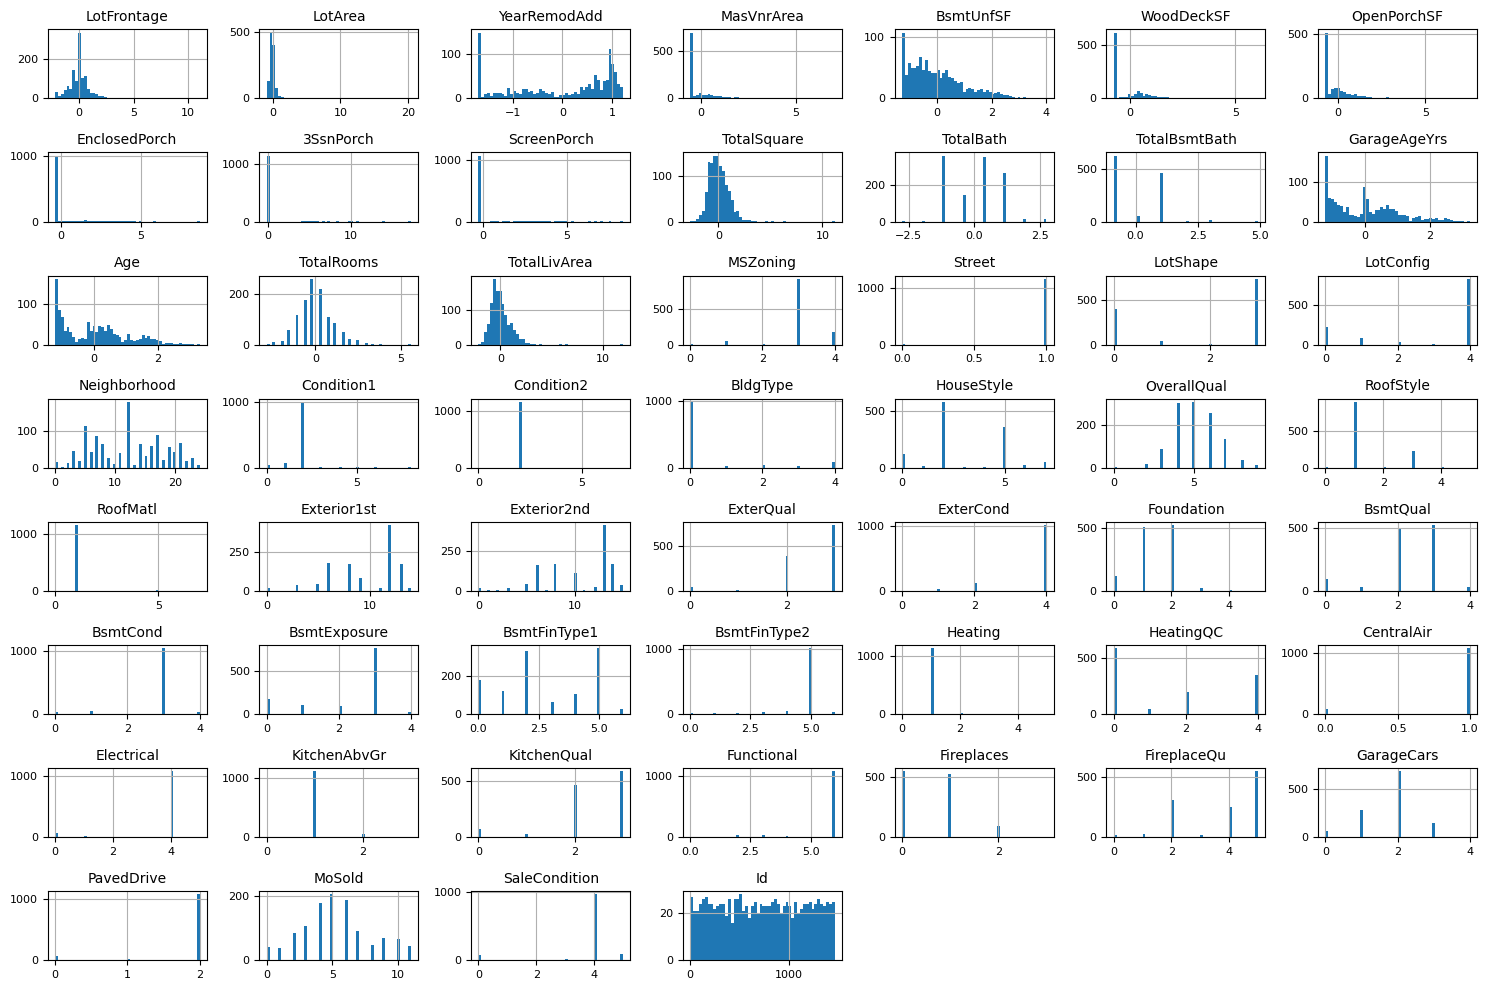

In [570]:
num_features2 = X_train.select_dtypes(exclude="object")

num_features2.hist(figsize=(15, 10), bins=50, xlabelsize=8, ylabelsize=8)
for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=10)
plt.tight_layout()
plt.show()

##### Соберем X_preproc и y_train

In [571]:
X_with_target = pd.concat([X_preproc.copy(), y.rename("target")], axis=1)

##### Таблица корреляции признаков с таргетом

In [572]:
corr_table = X_with_target.corr()["target"][:-1].sort_values(
    key=lambda x: abs(x), ascending=True
)
corr_table[abs(corr_table) < 0.1]

Condition2      0.001327
BsmtFinType2   -0.011503
Id             -0.017942
BsmtCond        0.022233
3SsnPorch       0.054900
MoSold          0.057329
Street          0.057369
BldgType       -0.072558
LotConfig      -0.072887
Name: target, dtype: float64

In [573]:
# corr_table2 = X_with_target.corr()["GarageArea"][:-1].sort_values(
#     key=lambda x: abs(x), ascending=True
# )
# corr_table2["GarageCars"]

##### F-тест

In [574]:
F_test_df = pd.Series(
    dict(zip(X_preproc.columns, f_regression(X_preproc, y)[1]))
).sort_values(ascending=False)
F_test_df[F_test_df > 0.05]

Condition2      0.959591
BsmtFinType2    0.660543
Id              0.493315
BsmtCond        0.395944
dtype: float64

> Эти по идее можно выкидывать

In [575]:
F_test_df[F_test_df < 0.05]

3SsnPorch         3.594757e-02
MoSold            2.848930e-02
Street            2.837931e-02
BldgType          5.541831e-03
LotConfig         5.331174e-03
RoofMatl          3.843499e-05
Condition1        9.015211e-06
ScreenPorch       3.408971e-06
Exterior1st       2.949187e-06
Exterior2nd       1.426260e-06
Functional        4.726788e-07
BsmtFinType1      8.583094e-08
Heating           7.955380e-08
KitchenAbvGr      1.478822e-08
ExterCond         1.174966e-08
EnclosedPorch     1.050808e-08
RoofStyle         6.042725e-13
MSZoning          3.445444e-13
Neighborhood      7.261916e-15
HouseStyle        1.093130e-16
BsmtUnfSF         9.318527e-18
TotalBsmtBath     4.620078e-20
SaleCondition     4.848670e-22
LotArea           1.643992e-23
LotShape          2.452204e-27
Electrical        1.493718e-30
BsmtExposure      1.482392e-32
PavedDrive        9.699221e-33
OpenPorchSF       2.344626e-36
WoodDeckSF        2.055324e-39
LotFrontage       1.084876e-39
CentralAir        9.855628e-44
Foundati

In [576]:
F_test_df["Utilities"]

KeyError: 'Utilities'

In [ ]:
X_train["GarageQual"].value_counts()

GarageQual
4    1050
5      64
1      36
2      13
0       3
3       2
Name: count, dtype: int64

In [ ]:
X[X["GarageArea"] == 0]["GarageCars"]

39      0
48      0
78      0
88      0
89      0
       ..
1349    0
1407    0
1449    0
1450    0
1453    0
Name: GarageCars, Length: 81, dtype: int64

##### Lasso

In [ ]:
lasso = Lasso(alpha=0.4)
lasso.fit(X_preproc, y)

,alpha,0.4
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [ ]:
lasso_df = pd.Series(dict(zip(X_preproc.columns, lasso.coef_))).sort_values(
    key=lambda x: abs(x), ascending=False
)
lasso_df

Id              -0.000012
LotFrontage      0.000000
YearBuilt        0.000000
YearRemodAdd     0.000000
MasVnrArea       0.000000
                   ...   
GarageQual       0.000000
PavedDrive       0.000000
MoSold           0.000000
SaleType        -0.000000
SaleCondition    0.000000
Length: 74, dtype: float64

##### Feature importance RandomForest

In [ ]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
importance_df = pd.Series(dict(zip(X.columns, rf.feature_importances_))).sort_values(
    key=lambda x: abs(x), ascending=False
)
importance_df[importance_df < 0.005]

Fence            0.004187
ScreenPorch      0.003843
Condition1       0.003825
BldgType         0.003801
Exterior1st      0.003747
GarageArea       0.003637
GarageQual       0.003079
BsmtFullBath     0.002542
GarageFinish     0.002312
LotArea          0.002300
HeatingQC        0.001890
GrLivArea        0.001859
OverallQual      0.001858
Heating          0.001852
GarageYrBlt      0.001809
FireplaceQu      0.001792
PoolQC           0.001761
MasVnrArea       0.001745
RoofMatl         0.001669
RoofStyle        0.001580
HalfBath         0.001557
GarageCars       0.001475
MasVnrType       0.001385
CentralAir       0.001344
Functional       0.001312
Electrical       0.001300
GarageType       0.001116
BsmtFinSF1       0.001043
KitchenQual      0.000939
BsmtCond         0.000832
BsmtUnfSF        0.000824
3SsnPorch        0.000821
1stFlrSF         0.000819
ExterCond        0.000810
Fireplaces       0.000754
OpenPorchSF      0.000746
YearBuilt        0.000736
LowQualFinSF     0.000725
KitchenAbvGr

In [ ]:
X_train_rnd = X_train.copy()
X_train_rnd["random"] = np.random.uniform(0, 100, size=X_train_rnd.shape[0])

In [ ]:
rf2 = RandomForestRegressor(random_state=42)

rf2.fit(X_train_rnd, y_train)

importance_rnd = pd.Series(
    dict(zip(X_train_rnd.columns, rf2.feature_importances_))
).sort_values(key=lambda x: abs(x), ascending=False)
importance_rnd[importance_rnd <= importance_rnd["random"]]

random           3.540732e-03
Fireplaces       3.078520e-03
BsmtFinType1     2.589371e-03
MasVnrArea       2.283411e-03
TotRmsAbvGrd     2.228328e-03
BsmtExposure     1.814740e-03
BedroomAbvGr     1.779163e-03
KitchenQual      1.768976e-03
EnclosedPorch    1.760749e-03
LandContour      1.604463e-03
Exterior1st      1.602378e-03
Exterior2nd      1.557676e-03
MSSubClass       1.552263e-03
YrSold           1.495169e-03
SaleCondition    1.467663e-03
ExterQual        1.419372e-03
Functional       1.393928e-03
HeatingQC        1.388877e-03
LotShape         1.321945e-03
ExterCond        1.304838e-03
FullBath         1.248278e-03
KitchenAbvGr     1.113364e-03
HouseStyle       1.021307e-03
BsmtFullBath     9.966764e-04
BsmtCond         9.308601e-04
RoofStyle        9.094721e-04
LotConfig        8.836133e-04
Condition1       8.528370e-04
Foundation       8.245625e-04
PavedDrive       7.866670e-04
GarageQual       7.602227e-04
HalfBath         7.488778e-04
ScreenPorch      6.421742e-04
Electrical

##### Permutation importance

In [ ]:
rf3 = RandomForestRegressor()

rf3.fit(X_train_rnd, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
r = permutation_importance(rf3, X_train_rnd, y_train, n_repeats=30, random_state=0)

In [ ]:
permutation_importances = pd.Series(
    dict(zip(X_train_rnd.columns, r["importances_mean"]))
).sort_values(key=lambda x: abs(x), ascending=False)
permutation_importances[permutation_importances <= permutation_importances["random"]]

random           0.001969
WoodDeckSF       0.001782
BsmtFinType1     0.001737
TotRmsAbvGrd     0.001703
KitchenQual      0.001473
EnclosedPorch    0.001427
SaleCondition    0.001401
MasVnrArea       0.001361
BsmtExposure     0.001336
PavedDrive       0.001283
LotShape         0.001202
BedroomAbvGr     0.001072
MSSubClass       0.001045
LandContour      0.001025
HeatingQC        0.000957
Exterior1st      0.000924
YrSold           0.000890
Exterior2nd      0.000850
ExterCond        0.000821
ExterQual        0.000739
BsmtFullBath     0.000589
Condition1       0.000589
Functional       0.000551
FullBath         0.000532
HouseStyle       0.000481
BsmtCond         0.000468
LotConfig        0.000439
Foundation       0.000423
RoofStyle        0.000407
HalfBath         0.000389
KitchenAbvGr     0.000385
GarageCond       0.000369
GarageQual       0.000358
ScreenPorch      0.000296
Electrical       0.000286
SaleType         0.000262
BsmtFinSF2       0.000247
LandSlope        0.000232
BldgType    